In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from pathlib import Path
import pandas as pd

SALARY_NAME = "hh_vacancies_salary_model.parquet"

DRIVE_DIR = Path("/content/drive/MyDrive/ColabNotebooks/FinalProject/ProcessedDatasets")

salary_path = DRIVE_DIR / SALARY_NAME

if salary_path.exists():
    df_salary = pd.read_parquet(salary_path)

else:
    from google.colab import files
    uploaded = files.upload()
    df_salary = pd.read_parquet(SALARY_NAME)

In [4]:
!pip -q install pymorphy3
import re
from tqdm.auto import tqdm
import pymorphy3

morph = pymorphy3.MorphAnalyzer()

token_re = re.compile(r"[a-zа-яё]{3,}", re.IGNORECASE)

def lemmatize_text(text: str) -> str:
    tokens = token_re.findall(str(text).lower())
    lemmas = [morph.parse(tok)[0].normal_form for tok in tokens]
    return " ".join(lemmas)

tqdm.pandas()

df_salary["description_lemma"] = df_salary["description_clean"].progress_apply(lemmatize_text)
for i in range(3):
    print(f"\n--- Пример {i+1} ---")
    print("RAW:  ", df_salary["description_clean"].iloc[i][:300])
    print("LEMMA:", df_salary["description_lemma"].iloc[i][:300])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 77.9 MB/s eta 0:00:00


  0%|          | 0/14131 [00:00<?, ?it/s]


--- Пример 1 ---
RAW:   в компанию на постоянную работу требуется сварщик оплата ежедневно 15 000 / 10 000 / 20 000 в день обязанности: выполнение сварочных работ по изготовлению навесов, перил, ворот, заборов, трубопроводов, мелких и средних металлоконструкций требования: опыт сварочных работ обязателен качество производи
LEMMA: компания постоянный работа требоваться сварщик оплата ежедневно день обязанность выполнение сварочный работа изготовление навес перила ворота забор трубопровод мелкий средний металлоконструкция требование опыт сварочный работа обязательный качество производить работа умение работать чертёж желательн

--- Пример 2 ---
RAW:   нежно - московская сеть салонов лазерной эпиляции и аппаратной коррекции фигуры . сейчас у нас открыто 28 beauty-кабинетов по москве. каждый месяц мы открываем по 2 новых кабинета и очень быстро растем. поэтому сейчас ищем несколько новых администраторов на запись клиентов (входящие звонки). чем зан
LEMMA: нежно московский сеть салон лазер

In [5]:
import numpy as np
import pandas as pd

text_col = "description_lemma"
if text_col not in df_salary.columns:
    raise ValueError("В df_salary нет столбца description_lemma")

df_nlp = df_salary.copy()

df_nlp = df_nlp[df_nlp["salary_mid"].notna()].copy()
df_nlp = df_nlp[df_nlp[text_col].notna()].copy()

df_nlp[text_col] = df_nlp[text_col].astype(str).str.strip()
df_nlp["text_len"] = df_nlp[text_col].str.len()

MIN_LEN = 50
df_nlp = df_nlp[df_nlp["text_len"] >= MIN_LEN].copy()

q25, q75 = df_nlp["salary_mid"].quantile([0.25, 0.75])
df_nlp["salary_group"] = np.where(df_nlp["salary_mid"] >= q75, "high",
                           np.where(df_nlp["salary_mid"] <= q25, "low", "mid"))

df_bin = df_nlp[df_nlp["salary_group"].isin(["high", "low"])].copy()
df_bin["y_high"] = (df_bin["salary_group"] == "high").astype(int)

print("Текстовый столбец:", text_col)
print("MIN_LEN:", MIN_LEN)
print("Квантили salary_mid: Q25 =", round(q25, 2), " Q75 =", round(q75, 2))

print("\nРаспределение salary_group (после фильтров):")
print(df_nlp["salary_group"].value_counts())

print("\nРазмер df_bin (только high/low):", df_bin.shape)
print("Баланс классов y_high:")
print(df_bin["y_high"].value_counts(normalize=True).round(3))

print("\nПроверка длины текста (len):")
print(df_bin["text_len"].describe().round(2))

Текстовый столбец: description_lemma
MIN_LEN: 50
Квантили salary_mid: Q25 = 80000.0  Q75 = 152250.0

Распределение salary_group (после фильтров):
salary_group
mid     6970
low     3610
high    3551
Name: count, dtype: int64

Размер df_bin (только high/low): (7161, 33)
Баланс классов y_high:
y_high
0    0.504
1    0.496
Name: proportion, dtype: float64

Проверка длины текста (len):
count    7161.00
mean     1324.71
std       727.02
min       116.00
25%       800.00
50%      1219.00
75%      1716.00
max      8395.00
Name: text_len, dtype: float64


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd

custom_stopwords = [
    "год", "компания", "работа", "обязанность",
    "требование", "умение", "навык", "опыт",
    "высокий", "доход", "заработный", "зарплата",
    "оплата", "вознаграждение"
]

vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=10,
    max_df=0.7,
    sublinear_tf=True,
    stop_words=custom_stopwords
)

X = vectorizer.fit_transform(df_bin["description_lemma"])
terms = np.array(vectorizer.get_feature_names_out())

mask_high = df_bin["y_high"].values == 1
mask_low = df_bin["y_high"].values == 0

mean_high = X[mask_high].mean(axis=0).A1
mean_low = X[mask_low].mean(axis=0).A1
diff = mean_high - mean_low

top_high_idx = np.argsort(diff)[-30:][::-1]
top_low_idx = np.argsort(diff)[:30]

top_high = pd.DataFrame({
    "term": terms[top_high_idx],
    "diff_high_minus_low": diff[top_high_idx]
})

top_low = pd.DataFrame({
    "term": terms[top_low_idx],
    "diff_high_minus_low": diff[top_low_idx]
})

print("\nHIGH:")
display(top_high.head(15))

print("\nLOW:")
display(top_low.head(15))


HIGH:


,term,diff_high_minus_low
0,разработка,0.012981
1,объект,0.011482
2,проект,0.010314
3,управление,0.009840
4,строительный,0.009756
5,продажа,0.009533
6,строительство,0.009117
7,технический,0.008711
8,переговоры,0.008193
9,рынок,0.008161



LOW:


,term,diff_high_minus_low
0,приём,-0.008729
1,уборка,-0.007772
2,товар,-0.007724
3,администратор,-0.007473
4,внимательность,-0.007137
5,порядок,-0.006851
6,гость,-0.006722
7,чистота,-0.006632
8,касса,-0.006618
9,медицинский,-0.006567


**Промежуточный вывод**

Высокая зарплата ассоциирована с управленческой, проектной и строительной деятельностью,
Низкая — с сервисной, торговой и операционной работой.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
import numpy as np
import pandas as pd

custom_stopwords = [
    "год", "компания", "работа", "обязанность",
    "требование", "умение", "навык", "опыт",
    "высокий", "доход", "заработный", "зарплата",
    "оплата", "вознаграждение"
]

vectorizer = CountVectorizer(
    ngram_range=(1, 2),
    min_df=10,
    max_df=0.7,
    stop_words=custom_stopwords,
    binary=True
)

X_counts = vectorizer.fit_transform(df_bin["description_lemma"])
terms = np.array(vectorizer.get_feature_names_out())

y = df_bin["y_high"].values

chi2_scores, p_values = chi2(X_counts, y)

sorted_idx = np.argsort(chi2_scores)[::-1]

top_chi2 = pd.DataFrame({
    "term": terms[sorted_idx],
    "chi2_score": chi2_scores[sorted_idx],
    "p_value": p_values[sorted_idx]
})

print("Размер Count матрицы:", X_counts.shape)
print("\nТОП-20 слов по chi-square:")
display(top_chi2.head(20))

Размер Count матрицы: (7161, 17818)

ТОП-20 слов по chi-square:


,term,chi2_score,p_value
0,разработка,472.223879,1.051571e-104
1,переговоры,349.031368,6.887694e-78
2,объект,348.534839,8.834890e-78
3,строительный,345.558753,3.929177e-77
4,строительство,339.239639,9.342525e-76
5,управление,322.051798,5.175824e-72
6,заказчик,318.500509,3.072735e-71
7,касса,301.919945,1.257432e-67
8,проектный,298.028081,8.859124e-67
9,рынок,266.458231,6.711829e-60


**Промежуточный вывод**

Результаты критерия χ² показали статистически значимую связь ряда терминов с уровнем заработной платы (p < 0.001). Термины, связанные с управлением, проектной деятельностью и строительством, характерны для высокооплачиваемых вакансий, тогда как слова, отражающие сервисную и торговую деятельность, ассоциированы с низкооплачиваемыми позициями.

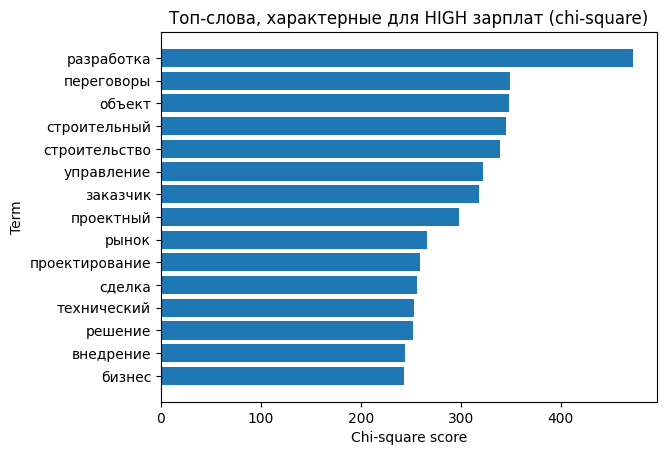

In [8]:
import matplotlib.pyplot as plt

high_terms = []

for term in top_chi2["term"]:
    idx = np.where(terms == term)[0][0]
    presence = X_counts[:, idx].toarray().ravel()

    if presence[y == 1].mean() > presence[y == 0].mean():
        high_terms.append(term)
    if len(high_terms) == 15:
        break

high_scores = []
for term in high_terms:
    idx = np.where(terms == term)[0][0]
    high_scores.append(chi2_scores[idx])

plt.figure()
plt.barh(high_terms[::-1], high_scores[::-1])
plt.title("Топ-слова, характерные для HIGH зарплат (chi-square)")
plt.xlabel("Chi-square score")
plt.ylabel("Term")
plt.show()

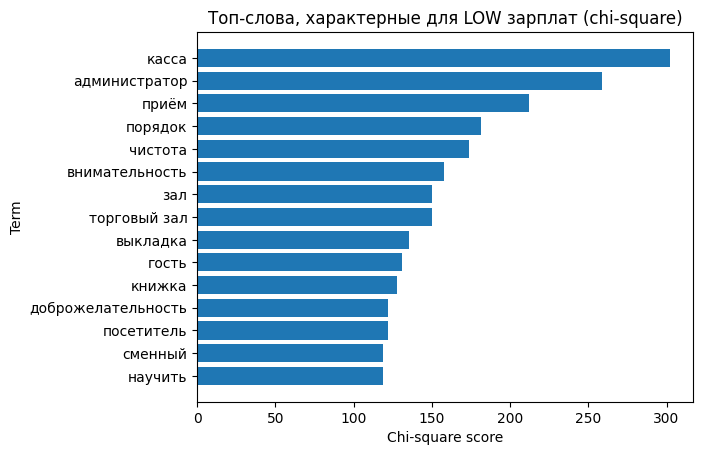

In [9]:
low_terms = []

for term in top_chi2["term"]:
    idx = np.where(terms == term)[0][0]
    presence = X_counts[:, idx].toarray().ravel()

    if presence[y == 0].mean() > presence[y == 1].mean():
        low_terms.append(term)
    if len(low_terms) == 15:
        break

low_scores = []
for term in low_terms:
    idx = np.where(terms == term)[0][0]
    low_scores.append(chi2_scores[idx])

plt.figure()
plt.barh(low_terms[::-1], low_scores[::-1])
plt.title("Топ-слова, характерные для LOW зарплат (chi-square)")
plt.xlabel("Chi-square score")
plt.ylabel("Term")
plt.show()

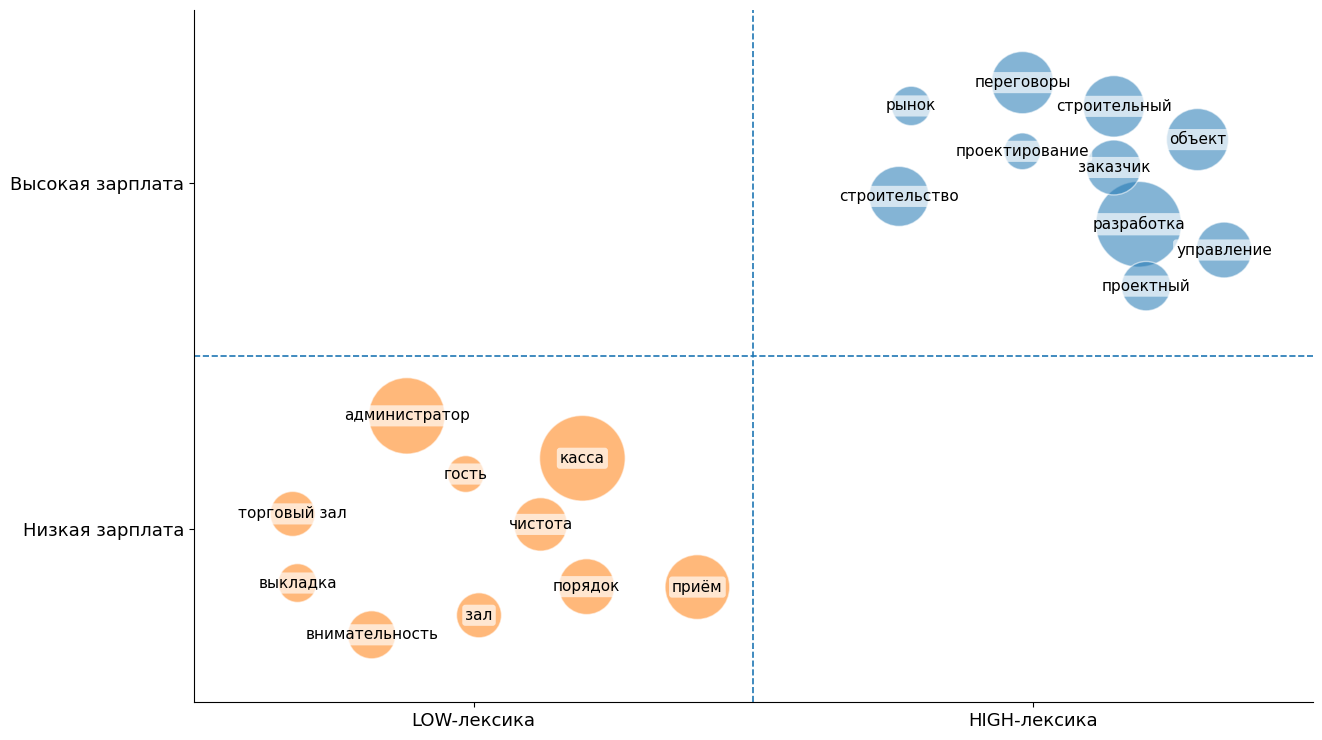

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "DejaVu Sans"

high_terms = []
low_terms = []

for term in top_chi2["term"]:
    idx_arr = np.where(terms == term)[0]
    if len(idx_arr) == 0:
        continue
    idx = idx_arr[0]

    presence = X_counts[:, idx].toarray().ravel()

    if presence[y == 1].mean() > presence[y == 0].mean():
        high_terms.append(term)

    if presence[y == 0].mean() > presence[y == 1].mean():
        low_terms.append(term)

    if len(high_terms) >= 10 and len(low_terms) >= 10:
        break

chi2_map = dict(zip(top_chi2["term"], top_chi2["chi2_score"]))

high_scores = [chi2_map[t] for t in high_terms[:10]]
low_scores  = [chi2_map[t] for t in low_terms[:10]]

high_df = pd.DataFrame({"term": high_terms[:10], "chi2_score": high_scores})
low_df  = pd.DataFrame({"term": low_terms[:10],  "chi2_score": low_scores})

term_col = "term"
diff_col = "chi2_score"

def scale_sizes(values, max_size=3800, min_size=700):
    v = np.abs(values).astype(float)
    if np.all(v == 0):
        return np.full_like(v, (max_size + min_size) / 2)
    v = (v - v.min()) / (v.max() - v.min() + 1e-9)
    return min_size + v * (max_size - min_size)

s_high = scale_sizes(high_df[diff_col].values)
s_low  = scale_sizes(low_df[diff_col].values)

rng = np.random.default_rng(42)

def init_positions(n, x_min, x_max, y_min, y_max):
    x = rng.uniform(x_min, x_max, n)
    y = rng.uniform(y_min, y_max, n)
    return np.c_[x, y]

pos_high = init_positions(len(high_df), 0.60, 0.92, 0.58, 0.92)
pos_low  = init_positions(len(low_df),  0.08, 0.40, 0.08, 0.42)

def repel(points, min_dist=0.06, bounds=(0,1,0,1), steps=400, lr=0.015):
    xmin, xmax, ymin, ymax = bounds
    pts = points.copy()

    for _ in range(steps):
        moved = False
        for i in range(len(pts)):
            for j in range(i+1, len(pts)):
                dx = pts[i,0] - pts[j,0]
                dy = pts[i,1] - pts[j,1]
                dist = (dx*dx + dy*dy) ** 0.5 + 1e-9
                if dist < min_dist:
                    push = (min_dist - dist) * lr
                    ux, uy = dx/dist, dy/dist
                    pts[i,0] += ux * push
                    pts[i,1] += uy * push
                    pts[j,0] -= ux * push
                    pts[j,1] -= uy * push
                    moved = True

        pts[:,0] = np.clip(pts[:,0], xmin, xmax)
        pts[:,1] = np.clip(pts[:,1], ymin, ymax)

        if not moved:
            break

    return pts

pos_high = repel(pos_high, min_dist=0.085, bounds=(0.58, 0.95, 0.55, 0.95))
pos_low  = repel(pos_low,  min_dist=0.10,  bounds=(0.05, 0.45, 0.05, 0.45))

x_high, y_high = pos_high[:,0], pos_high[:,1]
x_low,  y_low  = pos_low[:,0],  pos_low[:,1]

fig, ax = plt.subplots(figsize=(13.33, 7.5))  # 16:9

ax.scatter(x_high, y_high, s=s_high, alpha=0.55, edgecolor="white", linewidth=1.0)
ax.scatter(x_low,  y_low,  s=s_low,  alpha=0.55, edgecolor="white", linewidth=1.0)

ax.axhline(0.5, linestyle="--", linewidth=1.2)
ax.axvline(0.5, linestyle="--", linewidth=1.2)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xticks([0.25, 0.75])
ax.set_xticklabels(["LOW-лексика", "HIGH-лексика"], fontsize=13)
ax.set_yticks([0.25, 0.75])
ax.set_yticklabels(["Низкая зарплата", "Высокая зарплата"], fontsize=13)

ax.set_title("")

def add_labels(df, xs, ys):
    for i, term in enumerate(df[term_col].astype(str).tolist()):
        ax.text(
            xs[i], ys[i], term,
            ha="center", va="center",
            fontsize=11,
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.65)
        )

add_labels(high_df, x_high, y_high)
add_labels(low_df,  x_low,  y_low)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


In [10]:
import re
import numpy as np
import pandas as pd

if "key_skills" not in df_bin.columns:
    raise ValueError("В df_bin нет столбца key_skills.")

def skills_to_text(x):
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return ""
    if isinstance(x, list):
        out = []
        for item in x:
            if isinstance(item, dict):
                val = item.get("name", "")
            else:
                val = str(item)
            val = str(val).strip()
            if val:
                out.append(val.lower())
        return " ".join(out)
    s = str(x).strip().lower()
    return s

df_bin["skills_text"] = df_bin["key_skills"].apply(skills_to_text)

df_bin["skills_text"] = (
    df_bin["skills_text"]
    .str.replace(r"[/|;,]+", " ", regex=True)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

df_sk = df_bin[df_bin["skills_text"].str.len() > 0].copy()

print("Всего строк df_bin:", df_bin.shape[0])
print("Строк с непустыми навыками:", df_sk.shape[0])
print("Доля с навыками:", round(df_sk.shape[0] / df_bin.shape[0], 3))

display(df_sk[["key_skills", "skills_text", "salary_group", "salary_mid"]].head(5))

Всего строк df_bin: 7161
Строк с непустыми навыками: 4405
Доля с навыками: 0.615


,key_skills,skills_text,salary_group,salary_mid
0,"Сварочные работы, Сварщик, Сварка металлоконст...",сварочные работы сварщик сварка металлоконстру...,high,165000.0
1,"Телефонные переговоры, Ведение переписки, Навы...",телефонные переговоры ведение переписки навыки...,low,60000.0
2,"Выявление потребностей, Грамотная устная речь,...",выявление потребностей грамотная устная речь п...,high,305000.0
6,"Честность, Инициативность, Коммуникабельность,...",честность инициативность коммуникабельность ст...,high,500000.0
10,"MS PowerPoint, Английский язык, Деловое общени...",ms powerpoint английский язык деловое общение ...,high,160000.0


In [11]:
syn_map = {
    "postgres": "postgresql",
    "postgre": "postgresql",
    "postgre sql": "postgresql",
    "ms sql": "mssql",
    "microsoft sql": "mssql",
    "k8s": "kubernetes",
    "docker compose": "docker",
    "power bi": "powerbi",
    "tableau": "tableau",
    "etl": "etl",
    "dwh": "dwh",
    "ci cd": "ci/cd",
    "gitlab ci": "ci/cd",
    "github actions": "ci/cd",
    "ml": "machine learning",
    "machinelearning": "machine learning",
}

def normalize_skills_text(s: str) -> str:
    s = str(s).lower()
    for k, v in syn_map.items():
        s = s.replace(k, v)
    s = re.sub(r"[^a-zа-яё0-9\+\#\.\-\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df_sk["skills_text_norm"] = df_sk["skills_text"].apply(normalize_skills_text)

display(df_sk[["skills_text", "skills_text_norm"]].head(5))

,skills_text,skills_text_norm
0,сварочные работы сварщик сварка металлоконстру...,сварочные работы сварщик сварка металлоконстру...
1,телефонные переговоры ведение переписки навыки...,телефонные переговоры ведение переписки навыки...
2,выявление потребностей грамотная устная речь п...,выявление потребностей грамотная устная речь п...
6,честность инициативность коммуникабельность ст...,честность инициативность коммуникабельность ст...
10,ms powerpoint английский язык деловое общение ...,ms powerpoint английский язык деловое общение ...


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

skills_stopwords = ["год", "опыт"]

vec = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=10,
    max_df=0.8,
    sublinear_tf=True,
    stop_words=skills_stopwords
)

Xs = vec.fit_transform(df_sk["skills_text_norm"])
skills_terms = np.array(vec.get_feature_names_out())

mask_high = df_sk["y_high"].values == 1
mask_low = df_sk["y_high"].values == 0

mean_high = Xs[mask_high].mean(axis=0).A1
mean_low = Xs[mask_low].mean(axis=0).A1
diff = mean_high - mean_low

top_high_idx = np.argsort(diff)[-30:][::-1]
top_low_idx = np.argsort(diff)[:30]

skills_top_high = pd.DataFrame({
    "skill_term": skills_terms[top_high_idx],
    "mean_tfidf_high": mean_high[top_high_idx],
    "mean_tfidf_low": mean_low[top_high_idx],
    "diff_high_minus_low": diff[top_high_idx]
})

skills_top_low = pd.DataFrame({
    "skill_term": skills_terms[top_low_idx],
    "mean_tfidf_high": mean_high[top_low_idx],
    "mean_tfidf_low": mean_low[top_low_idx],
    "diff_high_minus_low": diff[top_low_idx]
})

print("Размер TF-IDF матрицы по навыкам:", Xs.shape)
print("\nТОП-15 навыков HIGH:")
display(skills_top_high.head(15))

print("\nТОП-15 навыков LOW:")
display(skills_top_low.head(15))

Размер TF-IDF матрицы по навыкам: (4405, 1720)

ТОП-15 навыков HIGH:


,skill_term,mean_tfidf_high,mean_tfidf_low,diff_high_minus_low
0,управление,0.033383,0.007685,0.025698
1,продажи,0.043220,0.017593,0.025627
2,продаж,0.029590,0.012802,0.016788
3,планирование,0.020002,0.004402,0.015601
4,привлечение,0.017534,0.002598,0.014937
5,привлечение клиентов,0.017439,0.002548,0.014892
6,поиск привлечение,0.017125,0.002552,0.014573
7,b2b,0.016577,0.002406,0.014170
8,клиентов,0.025482,0.011370,0.014112
9,строительство,0.014076,0.000425,0.013651



ТОП-15 навыков LOW:


,skill_term,mean_tfidf_high,mean_tfidf_low,diff_high_minus_low
0,работа,0.030393,0.052353,-0.021960
1,умение работать,0.011277,0.028402,-0.017126
2,работать,0.011626,0.028701,-0.017075
3,документооборот,0.004542,0.021206,-0.016664
4,пк,0.006113,0.022365,-0.016252
5,грамотная,0.011087,0.026435,-0.015348
6,речь,0.011087,0.026435,-0.015348
7,внимательность,0.010508,0.025198,-0.014690
8,пользователь пк,0.005876,0.020261,-0.014385
9,пользователь,0.006007,0.020252,-0.014245


**Промежуточный вывод**

Вакансии с низким уровнем заработной платы характеризуются операционными и сервисными функциями (касса, приём, торговый зал, уборка), а также базовыми требованиями к навыкам (внимательность, работа в коллективе, пользователь ПК). В отличие от высокооплачиваемых позиций, в данной группе отсутствуют признаки управленческой, проектной и коммерческой деятельности.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
import numpy as np
import pandas as pd

skills_stopwords = ["работа", "работать", "умение"]

vec_sk = CountVectorizer(
    ngram_range=(2, 2),
    min_df=10,
    max_df=0.8,
    binary=True,
    stop_words=skills_stopwords
)

X_sk = vec_sk.fit_transform(df_sk["skills_text_norm"])
terms_sk = np.array(vec_sk.get_feature_names_out())

y_sk = df_sk["y_high"].values

chi2_scores_sk, p_values_sk = chi2(X_sk, y_sk)

sorted_idx = np.argsort(chi2_scores_sk)[::-1]

top_chi2_sk = pd.DataFrame({
    "skill_bigram": terms_sk[sorted_idx],
    "chi2_score": chi2_scores_sk[sorted_idx],
    "p_value": p_values_sk[sorted_idx]
})

print("Размер Count матрицы по навыкам (биграммы):", X_sk.shape)
print("\nТОП-20 биграмм навыков по chi-square:")
display(top_chi2_sk.head(20))

Размер Count матрицы по навыкам (биграммы): (4405, 883)

ТОП-20 биграмм навыков по chi-square:


,skill_bigram,chi2_score,p_value
0,привлечение клиентов,156.026248,8.354719e-36
1,поиск привлечение,154.233297,2.059418e-35
2,b2b продажи,132.871230,9.647045e-31
3,заключение договоров,121.664738,2.733357e-28
4,руководство коллективом,105.061085,1.184281e-24
5,планирование продаж,101.357118,7.680872e-24
6,управление командой,101.235529,8.167120e-24
7,активные продажи,97.277051,6.027490e-23
8,пользователь пк,94.849186,2.054566e-22
9,развитие продаж,94.643120,2.279973e-22


Для выявления характерных навыков использовалась TF-IDF векторизация (униграммы и биграммы), позволяющая выявить наиболее информативные термы. Для статистического подтверждения различий применялся критерий χ² на уровне устойчивых биграмм навыков.

# Итоговый вывод

Анализ текстовых описаний и навыков показал устойчивое различие между группами вакансий по уровню заработной платы. Высокооплачиваемые позиции характеризуются управленческими, проектными и коммерческими компетенциями (управление командой, B2B продажи, привлечение клиентов, заключение договоров), тогда как низкооплачиваемые — операционными и административными функциями (кассовые операции, прием посетителей, пользователь ПК). Полученные результаты статистически значимы (χ², p < 0.001).

In [14]:
df_salary.to_parquet("hh_vacancies_salary_with_lemma.parquet")

In [15]:
from pathlib import Path

SALARY_LEMMA_NAME = "hh_vacancies_salary_with_lemma.parquet"
DRIVE_DIR = Path("/content/drive/MyDrive/ColabNotebooks/FinalProject/ProcessedDatasets")

def save_salary_with_lemma(df_salary):

    if DRIVE_DIR.exists():
        DRIVE_DIR.mkdir(parents=True, exist_ok=True)

        lemma_path = DRIVE_DIR / SALARY_LEMMA_NAME
        df_salary.to_parquet(lemma_path, index=False)
        return str(lemma_path)

    local_dir = Path("/content")
    lemma_path = local_dir / SALARY_LEMMA_NAME

    df_salary.to_parquet(lemma_path, index=False)

    from google.colab import files
    files.download(str(lemma_path))
    return str(lemma_path)

save_salary_with_lemma(df_salary)

'/content/drive/MyDrive/ColabNotebooks/FinalProject/ProcessedDatasets/hh_vacancies_salary_with_lemma.parquet'